---
title: SpatioTemporal Field - T2M - Stationary
subject: AEMET T2M
short_title: 2 - MCMC Inference
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CSIC
      - UCM
      - IGEO
    orcid: 0000-0002-6739-0053
    email: juanjohn@ucm.es
license: CC-BY-4.0
keywords: notation
---

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
import multiprocessing

num_devices = multiprocessing.cpu_count()
numpyro.set_platform("cpu")
# numpyro.set_host_device_count(4)
# num_chains = 5
numpyro.set_host_device_count(num_devices)

In [2]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray

from st_evt.utils import ExperimentPath
from omegaconf import OmegaConf

import jax
import jax.random as jrandom
import jax.numpy as jnp
import pandas as pd

rng_key = jrandom.PRNGKey(123)

from numpyro.infer import Predictive
import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)



# num_devices = 5
# numpyro.set_host_device_count(num_devices)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [3]:
# load dataset
dataset_path = autoroot.root.joinpath("data/ml_ready/aemet/t2max_stations_bm_summer.zarr")

# PARAMETERS
VARIABLE_NAME = "t2max"
COVARIATE_NAME = "gmst"
SPATIAL_DIM_NAME = "station_id"

# LOAD DATA
with xr.open_dataset(dataset_path, engine="zarr") as f:
    ds_bm = f.load()
    ds_bm = ds_bm.where(ds_bm.red_feten_mask == 1, drop=True)

ds_bm

<xarray.Dataset> Size: 73kB
Dimensions:         (gmst: 59, station_id: 154)
Coordinates:
    alt             (station_id) float32 616B 32.0 118.0 71.0 ... 620.0 10.0
  * gmst            (gmst) float64 472B 0.2447 0.1987 0.1827 ... 1.173 1.139
    lat             (station_id) float32 616B 40.96 41.15 41.19 ... 28.49 28.13
    lon             (station_id) float32 616B 0.87 1.108 1.217 ... -16.32 -15.42
    red_feten_mask  (station_id) uint8 154B 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * station_id      (station_id) <U5 3kB '0002I' '0016B' ... 'C447B' 'C659T'
    station_name    (station_id) <U50 31kB 'vandellòs' ... 'las palmas de g.c...
    time            (gmst) int64 472B 1961 1962 1963 1964 ... 2017 2018 2019
Data variables:
    t2max           (gmst, station_id) float32 36kB 32.2 33.32 ... 35.3 25.41

In [4]:
y = ds_bm[VARIABLE_NAME].values.squeeze()
num_temporal, num_spatial = y.shape
y.shape

(59, 154)

### Hierarchical Parameterization

In [5]:
# initialize empirical values
empirical_loc = ds_bm[VARIABLE_NAME].mean().values.squeeze()
empirical_std = ds_bm[VARIABLE_NAME].std().values.squeeze()

print(f"Loc: {empirical_loc.squeeze():.2f}")
print(f"Scale: {empirical_std.squeeze():.2f}")

empirical_loc_log = np.log(empirical_loc)
empirical_std_log = np.log(empirical_std)

print(f"Loc (log): {empirical_loc_log:.2f}")
print(f"Scale (log): {empirical_std_log:.2f}")

Loc: 36.18
Scale: 4.07
Loc (log): 3.59
Scale (log): 1.40


## Model

In [6]:
from jaxtyping import Float, Array
import equinox as eqx
import numpyro
import numpyro.distributions as dist
from tensorflow_probability.substrates.jax import distributions as tfd
from st_evt._src.models.gevd import StationaryUnPooledGEVD
from st_evt._src.modules.models.aemet.gevd_stationary_iid.model import init_t2m_model
from loguru import logger


In [7]:
model = init_t2m_model(
    y_values=ds_bm[VARIABLE_NAME].values,
    spatial_dim_name=SPATIAL_DIM_NAME,
    time_dim_name=COVARIATE_NAME,
    variable_name=VARIABLE_NAME,
    
)

2025-01-10 06:44:02.204 | DEBUG    | st_evt._src.modules.models.aemet.gevd_stationary_iid.model:init_t2m_model:75 - Initial Location: Normal(36.18, 4.07)
2025-01-10 06:44:02.205 | DEBUG    | st_evt._src.modules.models.aemet.gevd_stationary_iid.model:init_t2m_model:80 - Initial Scale: LogNormal(1.40, 0.5)


In [8]:
with numpyro.handlers.seed(rng_seed=123):
    y_sample = model(num_spatial=num_spatial, num_timesteps=num_temporal)



### Prior Predictions

In [9]:
import arviz as az

In [10]:
from numpyro.infer import Predictive

rng_key, rng_key_ = jrandom.split(rng_key)
prior_predictive = Predictive(model, num_samples=1_000)
prior_samples = prior_predictive(rng_key_)

In [11]:
az_ds_prior = az.from_numpyro(
    prior=prior_samples,
    dims=model.dimensions
    # pred_dims={"obs": ["time"]}
)

In [12]:
az_ds_prior

Inference data with groups:
	> prior

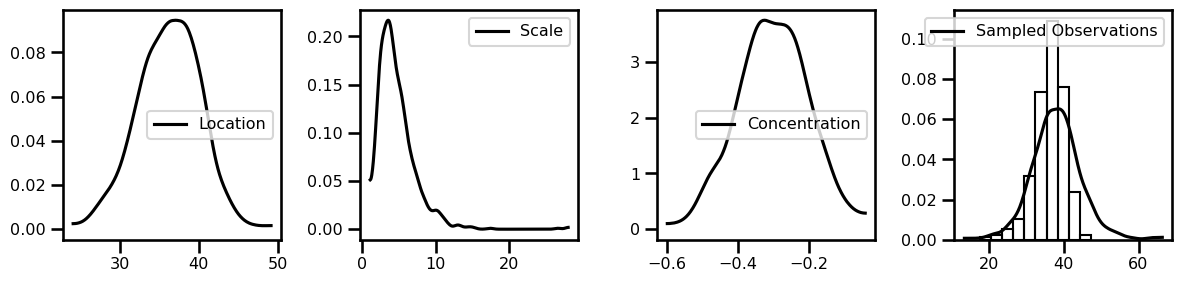

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(12,3))

az.plot_dist(prior_samples["location"], kind="kde", color="black", label="Location", ax=ax[0])
az.plot_dist(prior_samples["scale"], kind="kde", color="black", label="Scale", ax=ax[1])
az.plot_dist(prior_samples["concentration"], kind="kde", color="black", label="Concentration", ax=ax[2])
az.plot_dist(prior_samples[VARIABLE_NAME], kind="kde", color="black", label="Sampled Observations", ax=ax[3], plot_kwargs=dict(zorder=3))
# az.plot_dist(y.ravel(), kind="hist", color="black", label="Observations", ax=ax[3], plot_kwargs=dict(zorder=3))
ax[3].hist(y.ravel(), density=True, bins=10, fill=False, label="Observations")

# fig.savefig(figures_path.joinpath("density_prior.png"))

fig.set(
    dpi=100,
    size_inches=(12,3)
)

plt.tight_layout()
plt.show()

## Inference

In [14]:
from st_evt._src.models.inference import SVILearner, MCMCLearner

In [15]:
num_steps = 100_000

init_lr = 1e-10
peak_lr = 1e-3
end_lr = 1e-4
method = "map"
svi_learner = SVILearner(model, peak_lr=peak_lr, end_lr=end_lr, init_lr=init_lr, num_steps=num_steps, method=method)

svi_posterior = svi_learner(y=y)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:35<00:00, 2830.86it/s, init loss: 27003.1504, avg. loss [95001-100000]: 18423.4199]


In [17]:
# grab median params
init_params = svi_posterior.median_params

In [18]:
num_samples = 1_000
num_warmup = 1_000
num_chains = 8


mcmc_learner = MCMCLearner(
    model=model, 
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    init_params=init_params,
)

In [19]:
mcmc_posterior = mcmc_learner(y=y)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [20]:
# mcmc.print_summary(exclude_deterministic=False)

## Posterior

In [ ]:
posterior_samples = mcmc_posterior.mcmc.get_samples()

In [20]:
logger.info("Creating MCMC Data Structure...")
az_ds = mcmc_posterior.init_arviz_summary()

# correct coordinates
logger.info("Correcting Coordinates...")
az_ds = az_ds.assign_coords({COVARIATE_NAME: ds_bm[COVARIATE_NAME]})
az_ds = az_ds.assign_coords({SPATIAL_DIM_NAME: ds_bm[SPATIAL_DIM_NAME]})

2024-12-16 13:28:47.911 | INFO     | __main__:<module>:1 - Creating MCMC Data Structure...
2024-12-16 13:28:48.795 | INFO     | __main__:<module>:5 - Correcting Coordinates...


### Posterior Predictive

In [21]:
logger.info("Calculating Posterior Predictive Samples...")
# Posterior predictive samples
rng_key, rng_subkey = jrandom.split(rng_key)


posterior_predictive_samples = mcmc_posterior.posterior_predictive_samples(rng_subkey, num_timesteps=y.shape[0])


2024-12-16 13:28:49.011 | INFO     | __main__:<module>:1 - Calculating Posterior Predictive Samples...


In [23]:
logger.info("Creating Posterior Predictive Datastructure...")
az_ds_postpred = az.from_numpyro(
    posterior_predictive=posterior_predictive_samples,
    # log_likelihood=nll_postpred_samples,
    dims=model.dimensions,
    num_chains=num_chains,
)
# correct coordinates
logger.info("Correcting Coordinates...")
az_ds_postpred = az_ds_postpred.assign_coords({COVARIATE_NAME: ds_bm[COVARIATE_NAME]})
az_ds_postpred = az_ds_postpred.assign_coords({SPATIAL_DIM_NAME: ds_bm[SPATIAL_DIM_NAME]})

az_ds_postpred

2024-12-16 13:29:42.466 | INFO     | __main__:<module>:1 - Creating Posterior Predictive Datastructure...
2024-12-16 13:29:42.471 | INFO     | __main__:<module>:9 - Correcting Coordinates...


Inference data with groups:
	> posterior_predictive

#### Log-Likelihood

In [24]:
from numpyro.infer import log_likelihood

logger.info("Calculating Log-Likelihood for Posterior Predictive...")
nll_postpred_samples = log_likelihood(
    model=model,
    posterior_samples=posterior_predictive_samples,
    parallel=False,
    batch_ndim=1,
    y=y,
)

2024-12-16 13:29:44.932 | INFO     | __main__:<module>:3 - Calculating Log-Likelihood for Posterior Predictive...


In [25]:
az_ds_postpred_nll = az.from_numpyro(
    posterior_predictive=nll_postpred_samples,
    dims=model.dimensions,
    num_chains=num_chains,
).posterior_predictive[VARIABLE_NAME].rename("nll")

# correct coordinates
az_ds_postpred_nll = az_ds_postpred_nll.assign_coords({COVARIATE_NAME: ds_bm[COVARIATE_NAME]})
az_ds_postpred_nll = az_ds_postpred_nll.assign_coords({SPATIAL_DIM_NAME: ds_bm[SPATIAL_DIM_NAME]})

In [26]:
nll_postpred_samples[VARIABLE_NAME].shape

(8000, 59, 154)

In [27]:
logger.info("Adding extra coordinates")
az_ds_postpred.posterior_predictive["nll"] = az_ds_postpred_nll
az_ds_postpred.posterior_predictive[f"{VARIABLE_NAME}_true"] = (
    (COVARIATE_NAME, SPATIAL_DIM_NAME),
    np.asarray(y),
)

2024-12-16 13:29:47.586 | INFO     | __main__:<module>:1 - Adding extra coordinates


In [28]:
az_ds.add_groups(az_ds_postpred)
az_ds

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

#### MCMC Statistics

In [29]:
stats = az.waic(az_ds)
stats

/home/juanjohn/miniconda/envs/stevt/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 9086 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -18202.63    70.61
p_waic      336.05        -

There has been a warning during the calculation. Please check the results.

In [30]:

az_ds.log_likelihood.attrs["elpd_waic"] = stats.elpd_waic
az_ds.log_likelihood.attrs["se"] = stats.se
az_ds.log_likelihood.attrs["p_waic"] = stats.p_waic

### Save Data

In [31]:
mcmc_results_path = Path("/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/aemet/t2max/stationary_iid_mcmc_redfeten/results")
mcmc_results_path.mkdir(parents=True, exist_ok=True)
mcmc_results_path = mcmc_results_path.joinpath("stationary_iid_mcmc_redfeten.zarr")
az_ds.to_zarr(store=str(mcmc_results_path))

<zarr.hierarchy.Group '/'>